In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# Question 1

In [44]:
# Load the datasets
merge = pd.read_csv('Merge.csv')


def create_datasets():
    """
    Separates the merge dataset into 10min, 1h and d resolutions 
    """
    resolutions =['10MIN', '1H', 'D']
    datasets = {}
    for res in resolutions:
        data = merge[merge['Resolution'] == res]
        data.set_index('Datetime', inplace=True)
        data.index = pd.to_datetime(data.index)
        data = data.drop('Resolution', axis=1)
        data = data.rename(columns = {'Price':f'Price_{res}'})
        datasets[res] = data
    return datasets


def merge_data(data_10mins, data_60mins, data_1day):
    
    # Merge 10-mins and 60-mins data
    data_10mins = data_10mins.resample('2H').mean()
    data_60mins = data_60mins.resample('2H').mean()
    data_10_60 = pd.concat([data_10mins, data_60mins], axis=1, join='outer')

    # Forward fill the 1-day resolution data
    data_1day_ffill = data_1day.resample('2H').ffill()
    
    # Merge 2-hour and 1-day data
    merged_data = pd.concat([data_10_60, data_1day_ffill], axis=1, join='outer')
    
    # Filter only the rows between 7:00 and 17:00
    merged_data = merged_data.between_time('7:00', '17:00')
    
    return merged_data


## Question 1 Answer

In [45]:
datasets = create_datasets()
merged_data = merge_data(datasets['10MIN'], datasets['1H'], datasets['D'])
merged_data

,Price_10MIN,Price_1H,Price_D
Datetime,,,
2021-11-01 08:00:00,71.414583,71.5125,66.1
2021-11-01 10:00:00,70.347917,69.5750,66.1
2021-11-01 12:00:00,65.541667,64.6500,66.1
2021-11-01 14:00:00,64.685417,64.5750,66.1
2021-11-01 16:00:00,65.187500,67.0000,66.1
...,...,...,...
2021-11-30 08:00:00,98.237500,98.7500,NaN
2021-11-30 10:00:00,97.900000,97.5000,NaN
2021-11-30 12:00:00,96.037500,96.3750,NaN


# Question 2: 

In [46]:
consumption = pd.read_csv('Consumption.csv')

#  First we will need to clean the dates

def clean_dates(df):
    # Separate the valid from the invalid dates 
    date_pattern = re.compile(r'^\d{2}/\d{2}/\d{4}$') 

    # Filter out the rows with an invalid format and fix the format
    invalid_rows = ~df['Date'].str.match(date_pattern)
    invalid_df = df[invalid_rows]
    invalid_df['Date'] = pd.to_datetime(invalid_df['Date'], format='%Y%m%d')

    # Filter for the valid rows
    valid_rows = df['Date'].str.match(date_pattern)
    valid_df = df[valid_rows]
    valid_df['Date'] = pd.to_datetime(valid_df['Date'], format = '%d/%m/%Y')

    # Join dataframes back together
    final_df = pd.concat([valid_df,invalid_df])
    final_df = final_df.sort_values(by='Date')
    return final_df

def yearly_consumption(df):
    df = df.copy()
    df['Year'] = df['Date'].dt.year
    df['Date'] = df['Date'].dt.strftime('%m-%d')
    yearly_data = df.groupby(['Year', 'Date']).sum().unstack(level=0)
    yearly_data.columns = yearly_data.columns.droplevel()
    return yearly_data


def plot(data):
    
    data.set_index('Date', inplace=True)
    # Calculate the 5 year average
    c_average = data[data.index < '2021-01-01'].rolling(window='1825D').mean() 
    # Selecte years 2021 and 2022     
    years_2021_2022 = data[(data.index >= '2021-01-01') & (data.index  < '2023-01-01')]
    
    
    plt.figure(figsize=(15, 5))
    plt.plot(c_average, 'r--', label='5-year average')
    plt.plot(years_2021_2022, 'k-', label='2021 & 2022')
    plt.ylabel('Temperature (deg C)')
    plt.xlabel('Date')
    plt.grid(linestyle=':')

    # Create a shaded area for 2016-2020
    plt.fill_between(data[data.index < '2021-01-01'].index, 
                    data[data.index < '2021-01-01']['Consumption'].min(), 
                    data[data.index  < '2021-01-01']['Consumption'].max(), 
                    alpha=0.2, color='grey')
    plt.legend(loc='upper left')
    plt.show()


# Question 2 Answers

a) Yearly Consumption

In [47]:
consumption = clean_dates(consumption)
yearly = yearly_consumption(consumption)
yearly

C:\Users\bkhalidson\AppData\Local\Temp\ipykernel_27284\738678161.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invalid_df['Date'] = pd.to_datetime(invalid_df['Date'], format='%Y%m%d')
C:\Users\bkhalidson\AppData\Local\Temp\ipykernel_27284\738678161.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['Date'] = pd.to_datetime(valid_df['Date'], format = '%d/%m/%Y')


Year,2016,2017,2018,2019,2020,2021,2022
Date,,,,,,,
01-01,276.2910,339.5196,305.9370,313.6320,344.9952,344.0718,246.6612
01-02,294.6780,405.7614,365.8932,391.3758,380.8296,362.9772,263.8980
01-03,306.3096,407.3976,368.2746,424.1646,356.8698,365.1480,316.3698
01-04,370.0566,419.0454,372.1140,404.0766,348.2028,436.0716,348.6078
01-05,367.3998,457.1640,367.8534,364.0140,357.5502,446.6340,360.4338
...,...,...,...,...,...,...,...
12-27,329.5728,347.8140,358.4736,337.5432,320.3550,330.2694,NaN
12-28,352.5606,357.4044,356.5296,343.2780,363.7872,311.3802,NaN
12-29,365.2614,351.6534,330.2370,338.0292,365.9094,299.7648,NaN


b) Seasonal Plot
Obvservation: 
- Looks like energy consumption is the highest in the beginning of the year and starts to decrease as the year goes by. This could be because the beginning of the year is the coldest period so people tend to use their heating and hot water a lot more to keep warm. Moreover, people tend to use dryers vs hanging clothes outside more due to the reduced sunny periods. 
- Energy consumption seems to be decreasing over time and 2022 appears to be mostly below the 2016-2020 consumption average, thus indicating that households are becoming more energy efficient or using less energy than the average. 




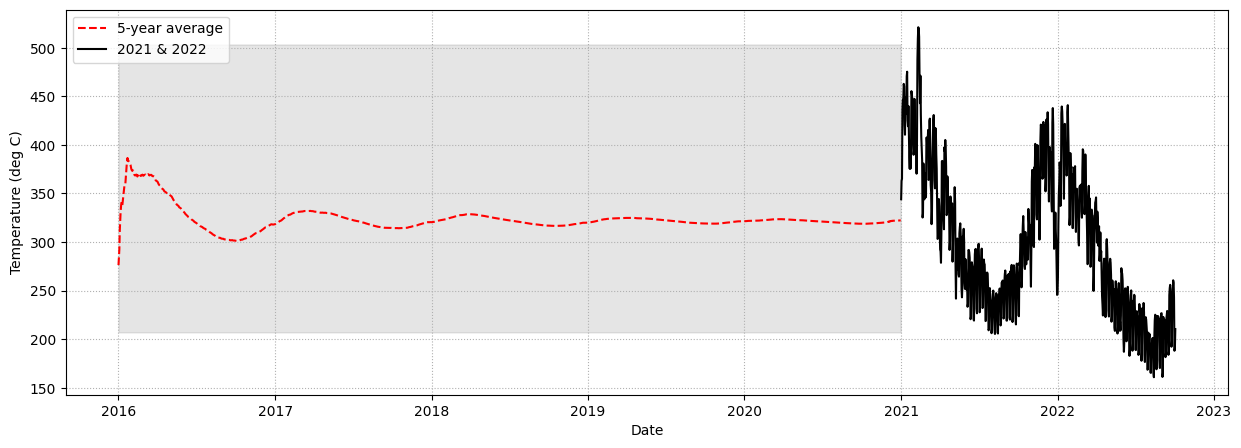

In [48]:

plot(consumption)

# Question 3 answer

In [32]:

def clean_string(string):
    valid_numbers = []
    return check(string, valid_numbers)

def check(string,valid_numbers):
    string = string.split()
    all_valid = False
    for s in string: 
        # Check if the number makes a valid use of the comma
        if check_validity(s) == True:
            valid_numbers.append(s)
            all_valid = True
        else:
            all_valid == False

    if all_valid == True:
        return " ".join(valid_numbers)

    #  If the numbers aren't valid, process to remove spaces and join the two numbers
    if all_valid == False:
            first_number = string[0] + string[1]
            second_number = ''.join(string[2:])
            return first_number + ' ' + second_number

def check_validity(s):
    #  Check whether the number has enough for a thousand
    #  formula = 4c + 1 where c is the comma count
    comma_count = s.count(',')
    if comma_count == 0:
        return False
    if len(s) < 4 * comma_count + 1:
        return False
    else:
        return True 

example_1 = '1,247 4,568,123' 
example_2 = '1,2 47 4,56 8,1 23'

print(clean_string(example_1))
print(clean_string(example_2))


1,247 4,568,123
1,247 4,568,123


# Question 4 Answer

In [42]:
def process_trades(file, begin, end, products, freq):
    # Read the csv file into a DataFrame and parse the TradeDateTime column as a datetime
    df = pd.read_csv(file, parse_dates=['TradeDateTime'])
    
    # Filter the DataFrame to only include rows within the specified begin and end dates
    df = df[(df['TradeDateTime'] >= begin) & (df['TradeDateTime'] <= end)]
    
    # Replace the values of the Product column to combine "Emission - Venue A" and "Emission - Venue B" into a single product
    df['Product'] = df['Product'].replace({'Emission - Venue A': 'Emission', 'Emission - Venue B': 'Emission'})
    
    # Filter the DataFrame to only include rows with the specified products
    df = df[df['Product'].isin(products)]
    
    # Set the TradeDateTime column as the index of the DataFrame
    df = df.set_index('TradeDateTime')
    
    # If the frequency is less than 1 day, limit the output to trading hours (7:00-17:00)
    if pd.Timedelta(freq) < pd.Timedelta('1D'):
        df = df.between_time('7:00', '17:00')
    
    # If the product list has more than one contract, group the DataFrame by Contract and resample at the specified frequency
    if len(products) > 1:
        df = df.groupby(['Contract', pd.Grouper(freq=freq)]).agg({'Price': 'ohlc', 'Quantity': 'sum'})
        df.columns = ['open', 'high', 'low', 'close', 'volume']
        df = df.reset_index()
    # Otherwise, resample the DataFrame at the specified frequency without grouping by Contract
    else:
        df = df.resample(freq).agg({'Price': 'ohlc', 'Quantity': 'sum'})
        df.columns = ['open', 'high', 'low', 'close', 'volume']
    
    # Return the resulting DataFrame
    return df

# Example
trades_file = 'Trades.csv'
begin = pd.Timestamp('2022-04-18 07:00:00')
end = pd.Timestamp('2022-04-20 17:00:00')
products = ['Emission - Venue B','Emission - Venue A']
freq = '1D'


process_trades(trades_file, begin, end, products, freq)

,Contract,TradeDateTime,open,high,low,close,volume
0,Q01,2022-04-18,24.1550,24.2000,23.4250,24.0725,18509
1,Q01,2022-04-19,24.2550,24.6225,23.8125,23.9525,21105
2,Q01,2022-04-20,24.0725,24.3825,22.5650,22.9600,27930
